In [1]:
%pylab inline
figsize(8, 6)

Populating the interactive namespace from numpy and matplotlib


## Import

In [2]:
import pandas
import numpy
from folding_group import FoldingGroupClassifier
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
from utils import get_events_number, get_events_statistics

## Reading initial data

In [4]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('datasets/MC/csv/Bu_JPsiK/Tracks.root'))

In [5]:
print len(data)
data = data.ix[numpy.isfinite(data.IPs), :]
print len(data)

15065985
15056277


In [6]:
data.head()

,run,event,Bmass,i,mult,partP,partPt,ptB,IPs,IP,...,Dist_phi,N_sig_sw,mu_cut,e_cut,K_cut,MCID,OS_SS,xFlag,K_MCID,BOosc
0,2517778,1110804,5.272273,0,12,10.10731,1.275867,3.046546,45.846935,1.163320,...,0.318931,0,0,0,1,-321,0,0,0,0
1,2517778,1110804,5.272273,1,12,12.52366,0.513155,3.046546,4.899704,0.284941,...,1.151553,0,0,0,0,211,0,0,0,0
2,2517778,1110804,5.272273,2,12,4.71373,0.597545,3.046546,3.352034,0.127440,...,0.544899,0,0,0,0,-211,-1,-1,0,0
3,2517778,1110804,5.272273,3,12,4.68713,0.243792,3.046546,102.329247,8.423534,...,0.395680,0,0,0,0,-211,0,0,0,0
4,2517778,1110804,5.272273,4,12,3.21920,0.612911,3.046546,1.016178,0.065894,...,0.269237,0,0,0,0,211,-1,-1,0,0


In [7]:
event_id_column = 'event_id'
event_id = data.run.apply(str) + '_' + data.event.apply(str)
data['group_column'] = numpy.unique(event_id, return_inverse=True)[1]
# all weights are 1, because this is MC
data['N_sig_sw'] = 1
data[event_id_column] = event_id

In [8]:
get_events_statistics(data)

{'Events': 657443, 'parts': 15056277}

In [9]:
from utils import compute_N_B_events_MC
N_B_events = compute_N_B_events_MC('datasets/MC/csv/Bu_JPsiK/Tracks.root', 'datasets/MC/csv/Bu_JPsiK/Vertices.root')
N_B_events

1488891.0

In [10]:
import json
with open('models/JPsiKMC.json', 'w') as f:
    json.dump({'N_B_events': N_B_events}, f)

## Add diff_pt and cos(diff_phi)

In [11]:
from utils import add_diff_pt
# add diff pt
add_diff_pt(data)
# add cos(diff_phi)
data.loc[:, 'cos_diff_phi'] = numpy.cos(data.diff_phi.values)

## Add max, sum among PIDs

In [12]:
from itertools import combinations
PIDs = {'k': data.PIDNNk.values,
        'e': data.PIDNNe.values,
        'mu': data.PIDNNm.values,
       }
for (pid_name1, pid_values1), (pid_name2, pid_values2) in combinations(PIDs.items(), 2):
    data.loc[:, 'max_PID_{}_{}'.format(pid_name1, pid_name2)] = numpy.maximum(pid_values1, pid_values2)
    data.loc[:, 'sum_PID_{}_{}'.format(pid_name1, pid_name2)] = pid_values1 + pid_values2

## define `label` = `signB` * `signTrack`

* if > 0 (same sign) - label **1**
* if < 0 (different sign) - label **0**

In [13]:
data.loc[:, 'label'] = (data.signB.values * data.signTrack.values > 0) * 1

In [14]:
', '.join(data.columns)

'run, event, Bmass, i, mult, partP, partPt, ptB, IPs, IP, IPerr, partlcs, EOverP, ghostProb, IPPU, nnkrec, PIDNNk, PIDNNpi, PIDNNp, PIDNNm, PIDNNe, diff_eta, diff_phi, phi, eta, proj, ID, veloch, signB, signTrack, Dist_phi, N_sig_sw, mu_cut, e_cut, K_cut, MCID, OS_SS, xFlag, K_MCID, group_column, event_id, diff_pt, cos_diff_phi, max_PID_mu_k, sum_PID_mu_k, max_PID_mu_e, sum_PID_mu_e, max_PID_k_e, sum_PID_k_e, label'

## Apply ghost prob cut

In [15]:
initial_cut = '(ghostProb < 0.4)'
data = data.query(initial_cut)

In [16]:
get_events_statistics(data)

{'Events': 1488885, 'tracks': 32813556}

## Leave not muons, kaons, electrons, protons, pions

In [17]:
threshold_kaon = 0.
threshold_muon = 0.
threshold_electron = 0.
threshold_pion = 0.
threshold_proton = 0.
cut_pid = " ( (PIDNNk > {trk}) | (PIDNNm > {trm}) | (PIDNNe > {tre}) | (PIDNNpi > {trpi}) | (PIDNNp > {trp})) "
cut_pid = cut_pid.format(trk=threshold_kaon, trm=threshold_muon, tre=threshold_electron, trpi=threshold_pion, 
                         trp=threshold_proton)
data = data.query(cut_pid)

In [18]:
get_events_statistics(data)

{'Events': 1488885, 'tracks': 32808324}

## Tracks sum of charges asymmetry checks

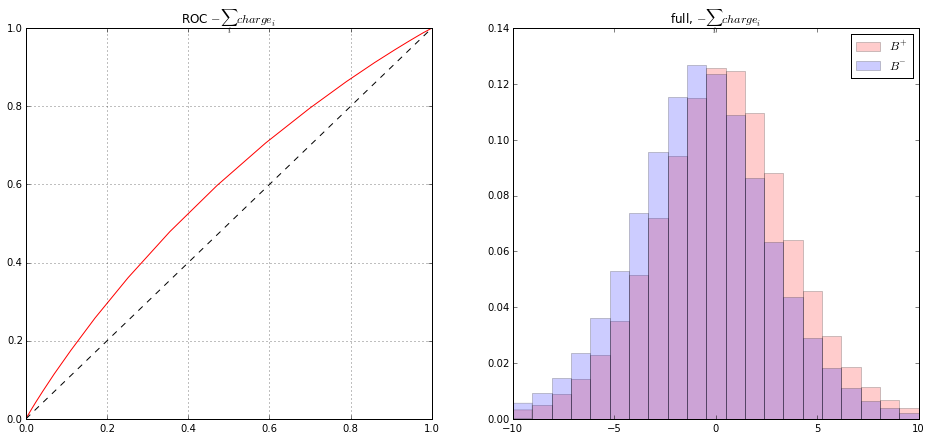

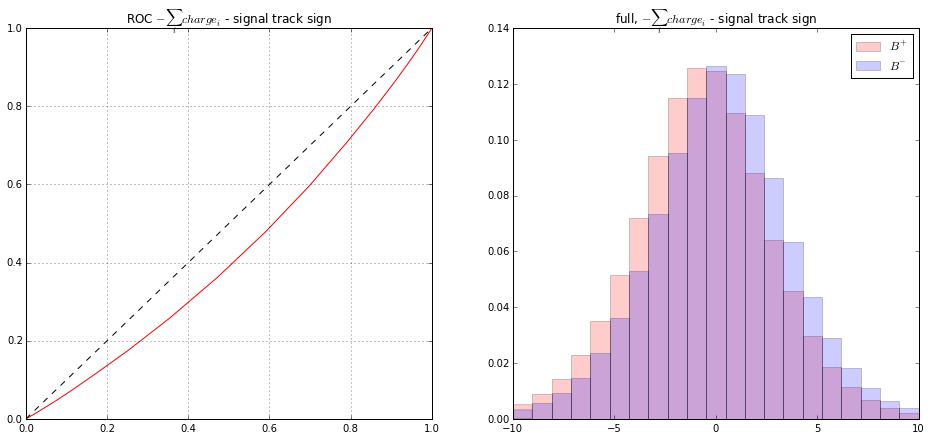

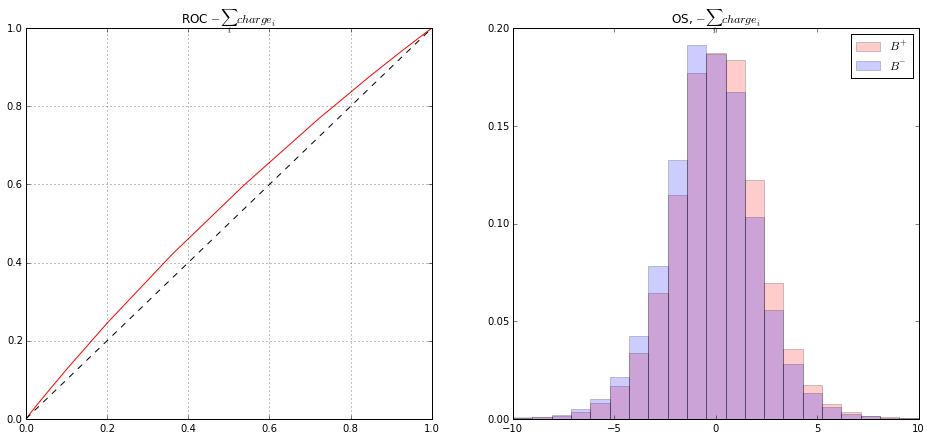

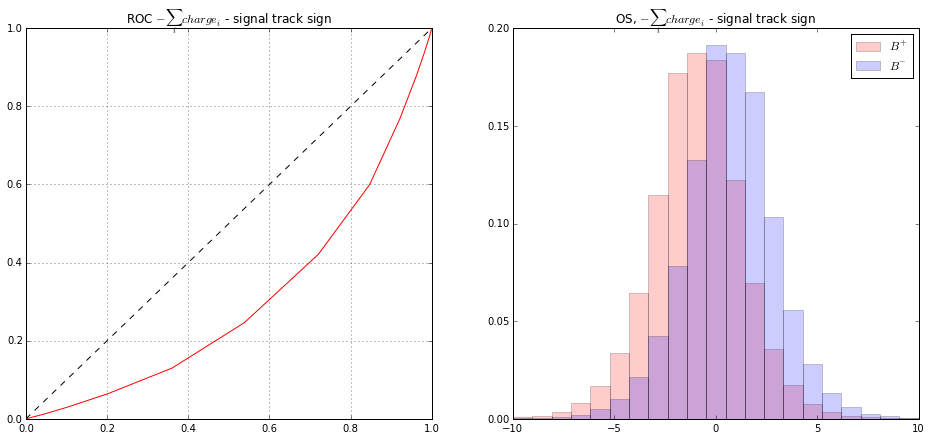

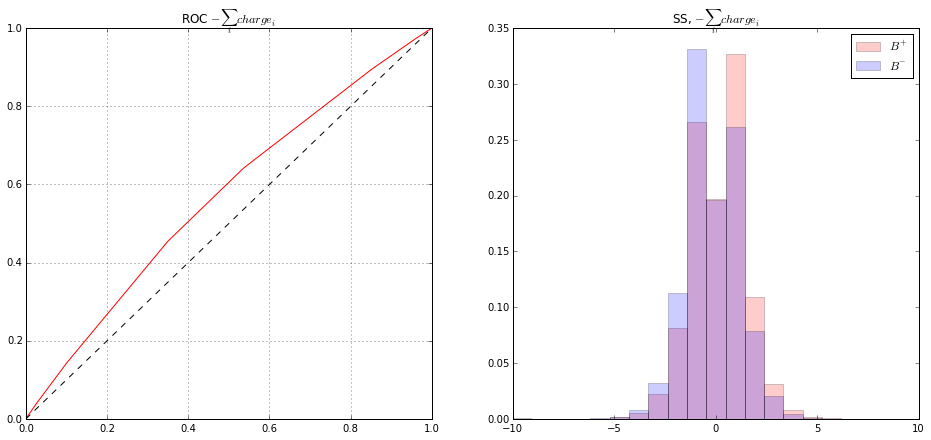

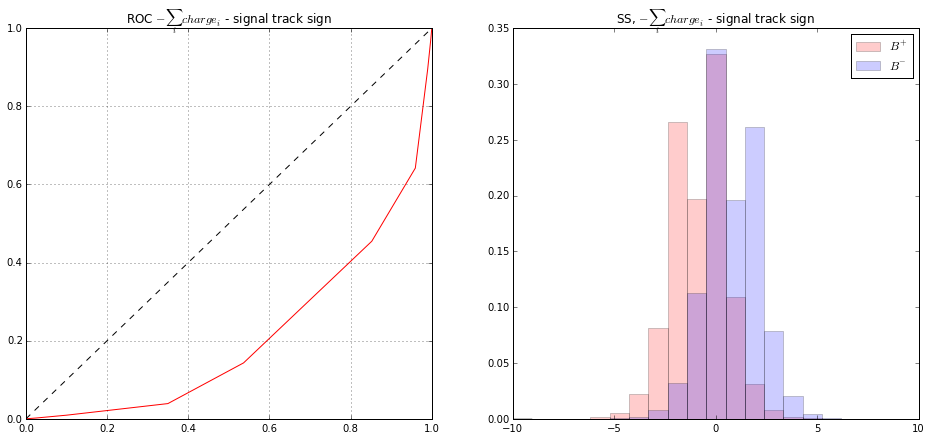

In [19]:
from utils import compute_sum_of_charges
means = [compute_sum_of_charges(data[mask], name, bins=bins,
                                event_id_column=event_id_column) for mask, name, bins in \
         zip([data.signB > -100, 
              (data.IPs > 3) & ((abs(data.diff_eta) > 0.6) | (abs(data.diff_phi) > 0.825)), 
              (abs(data.diff_eta) < 0.6) & (abs(data.diff_phi) < 0.825) & (data.IPs < 3)], 
             ['full', 'OS', 'SS'], [21, 21, 21])]

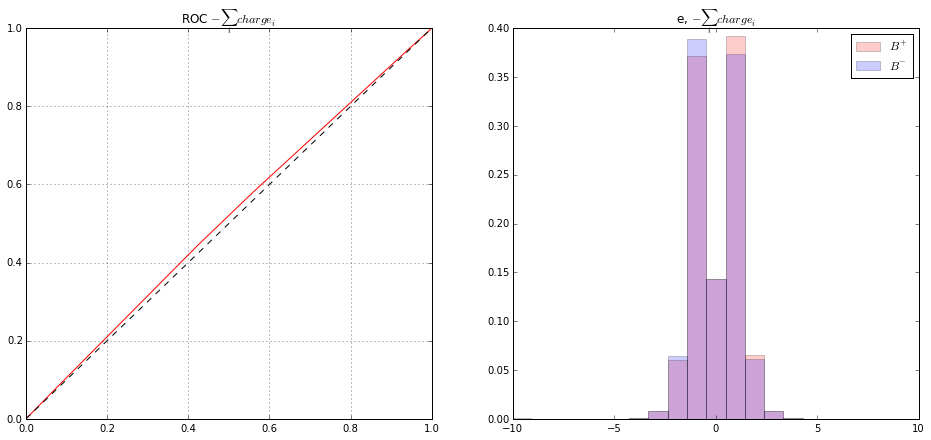

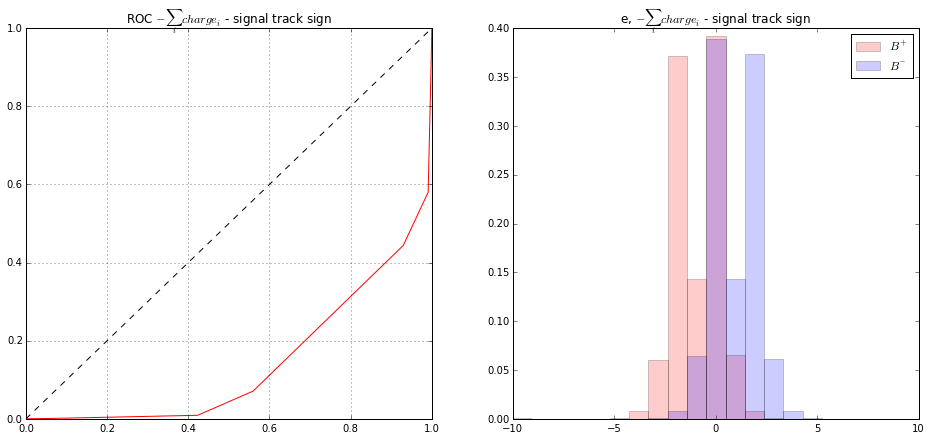

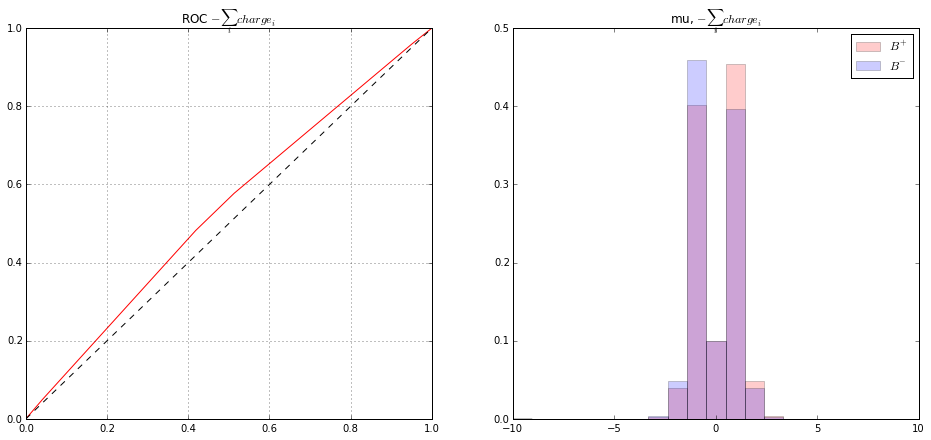

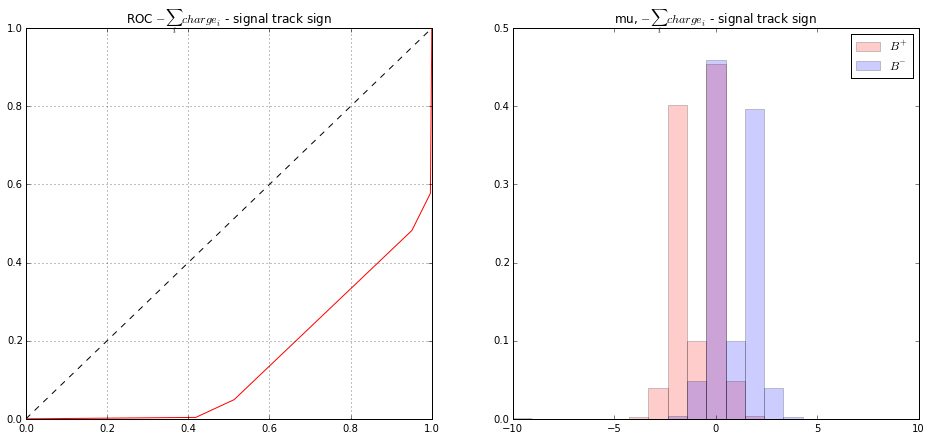

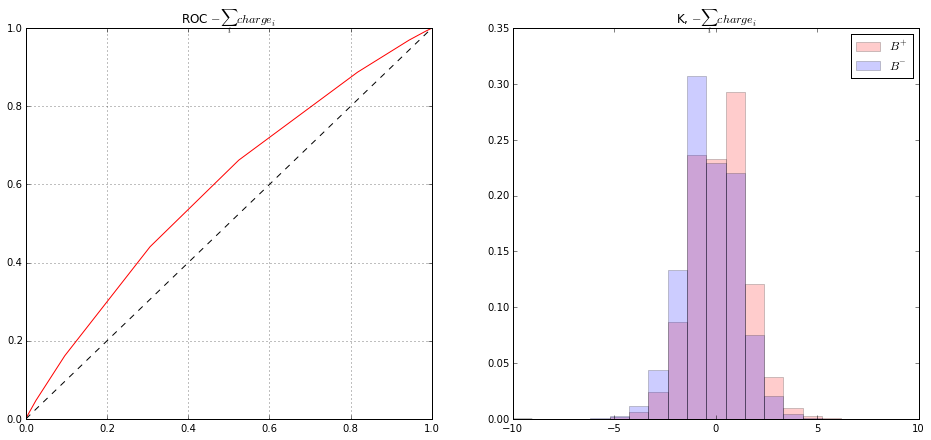

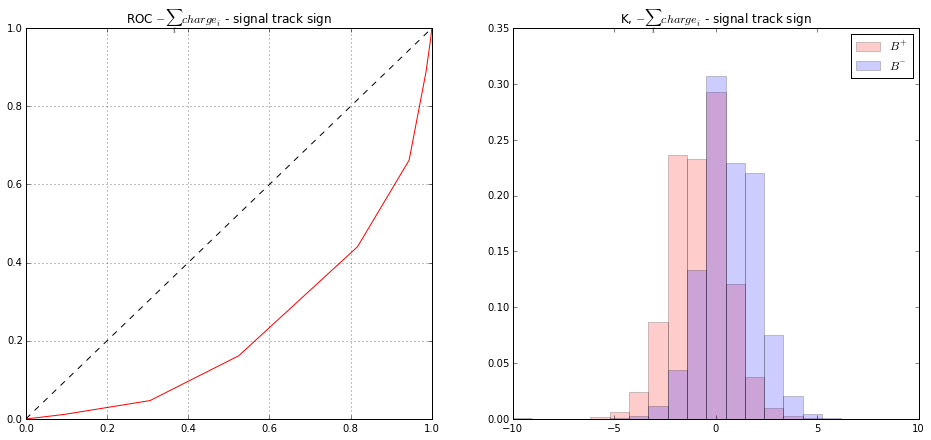

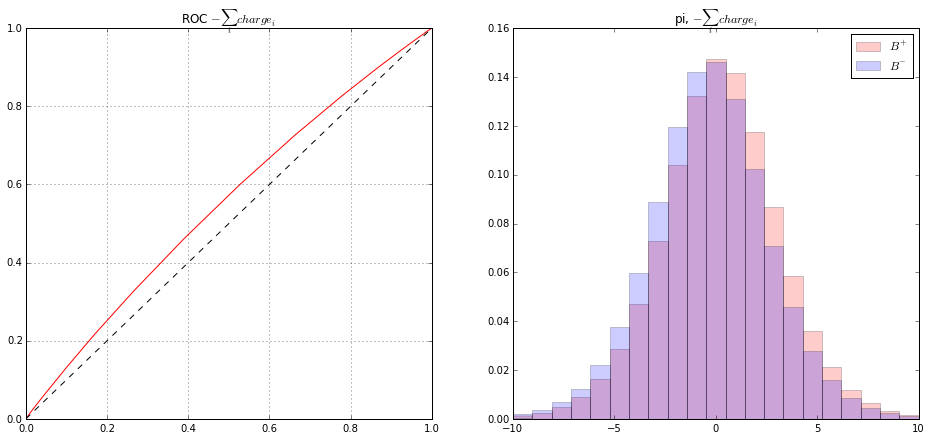

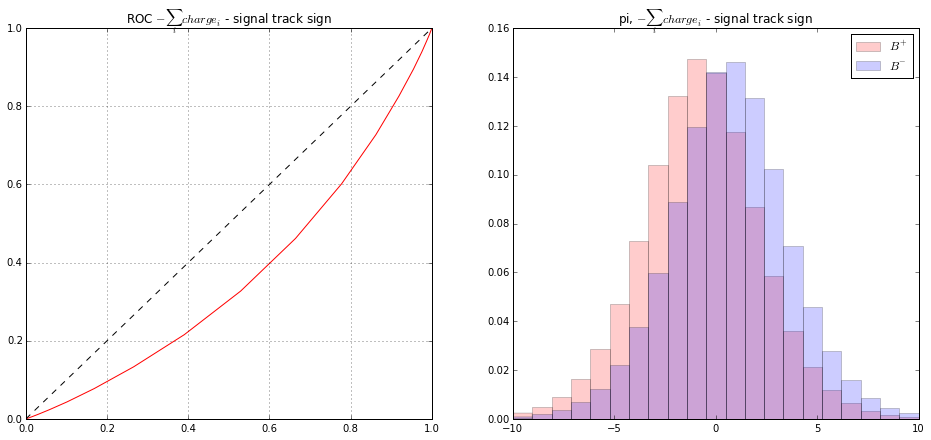

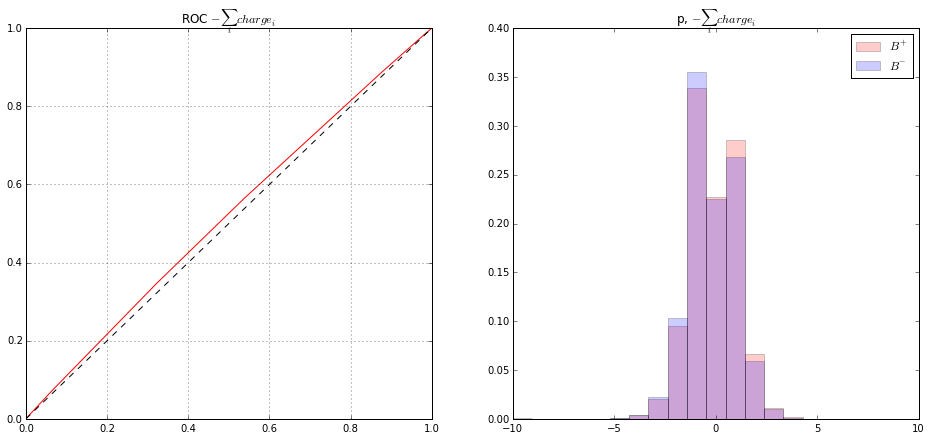

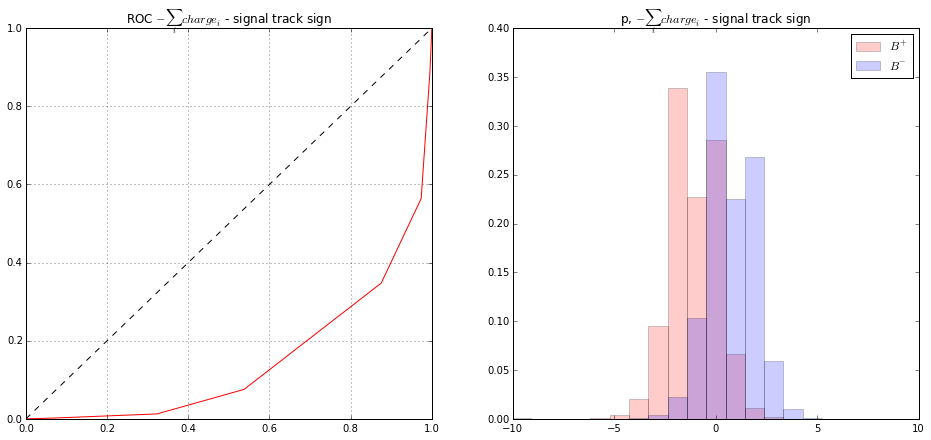

In [20]:
means_mcid = [compute_sum_of_charges(data[mask], name, bins=bins,
                                event_id_column=event_id_column) for mask, name, bins in \
         zip([numpy.abs(data.MCID) == 11, numpy.abs(data.MCID) == 13, numpy.abs(data.MCID) == 321,
              numpy.abs(data.MCID) == 211, numpy.abs(data.MCID) == 2212], 
             ['e', 'mu', 'K', 'pi', 'p'], [21, 21, 21, 21, 21])]

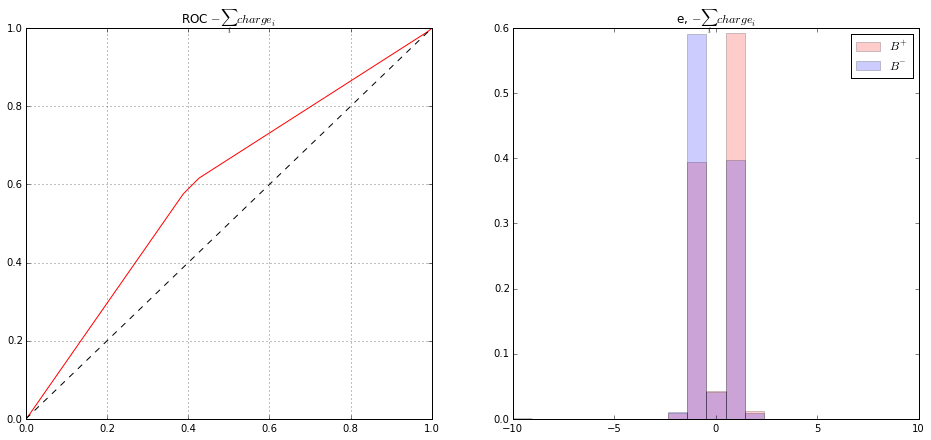

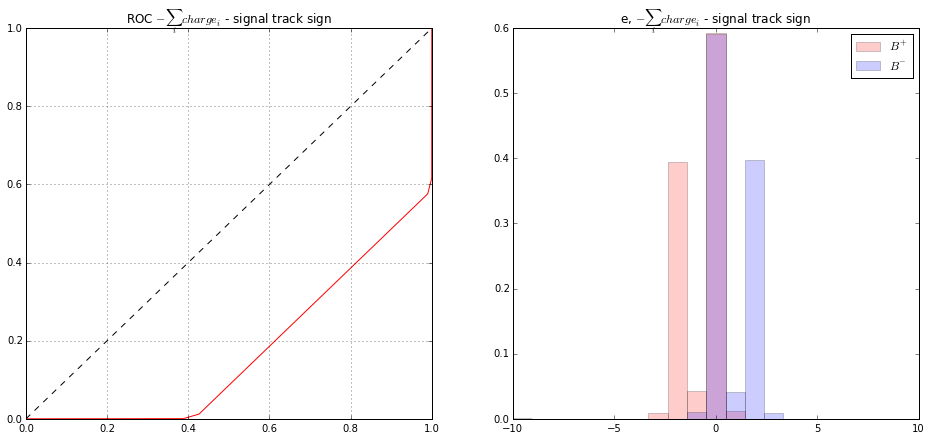

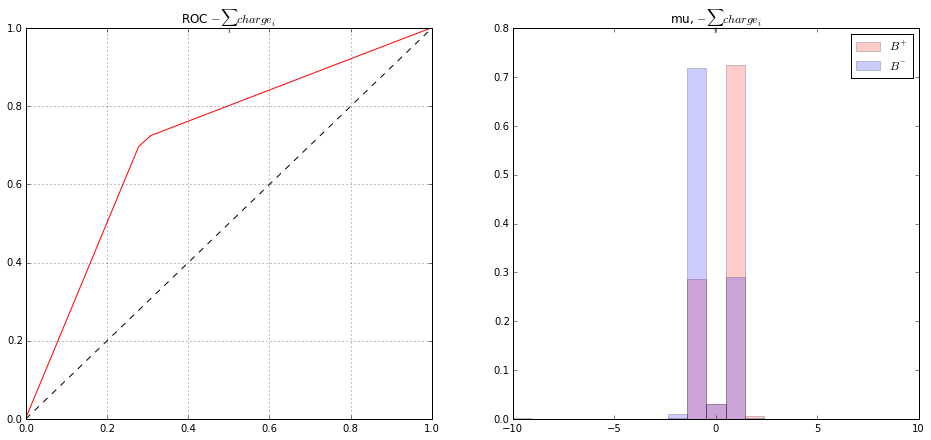

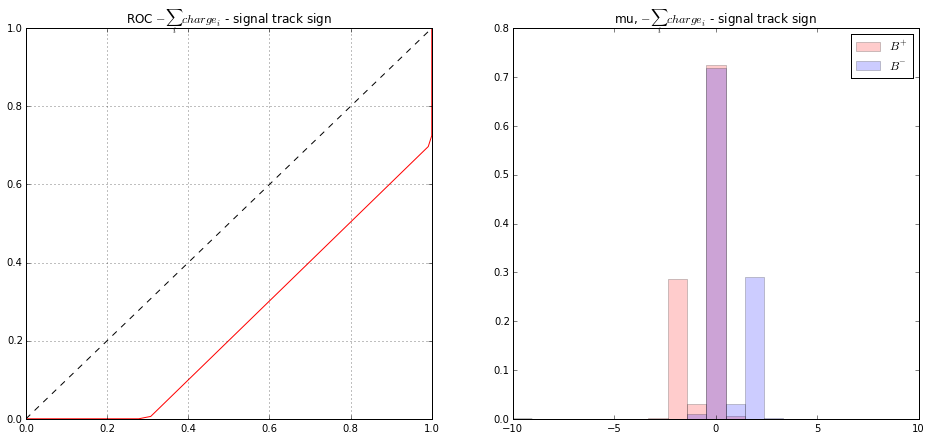

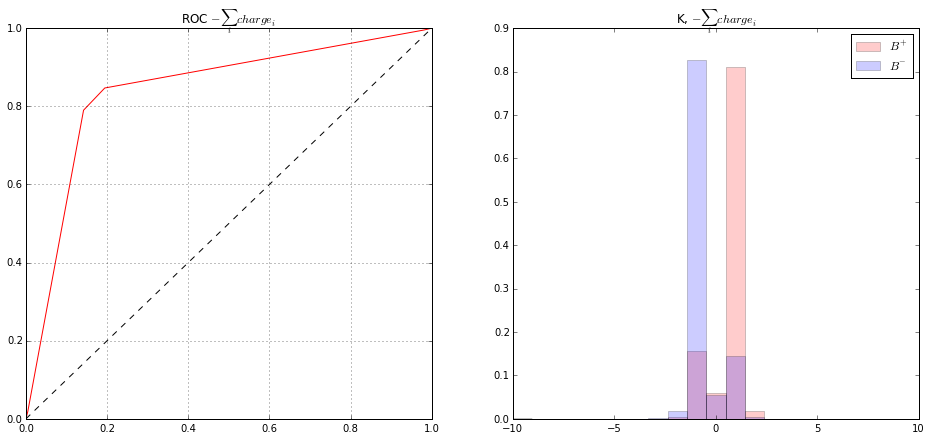

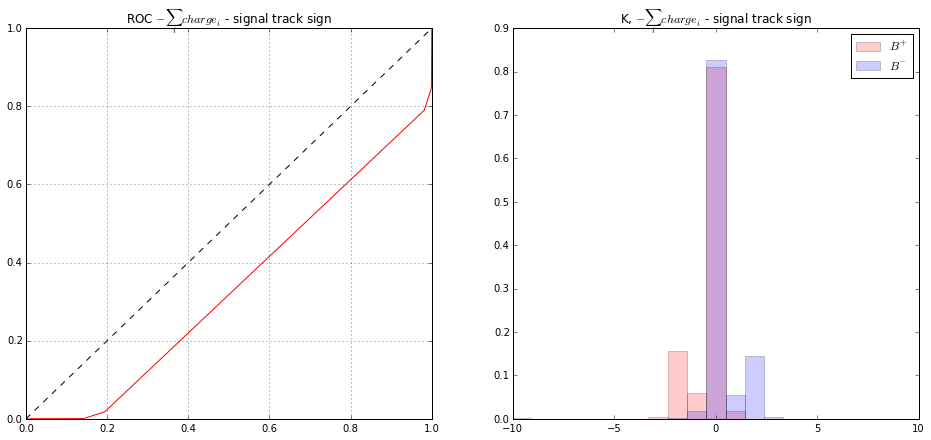

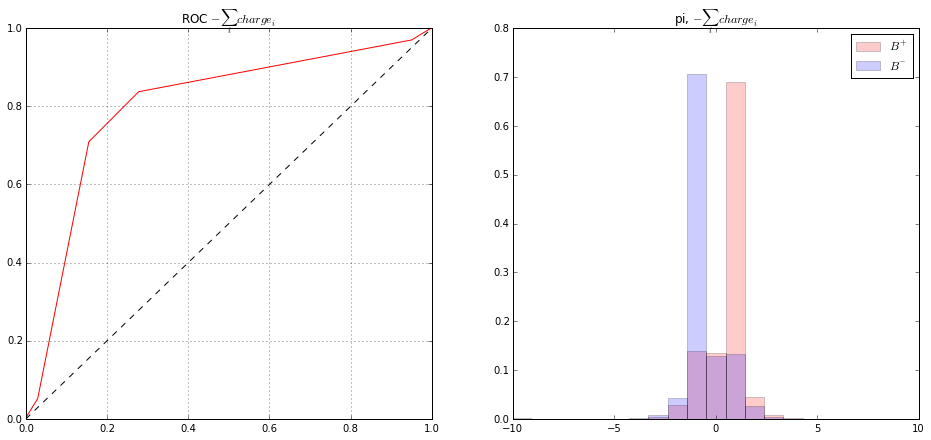

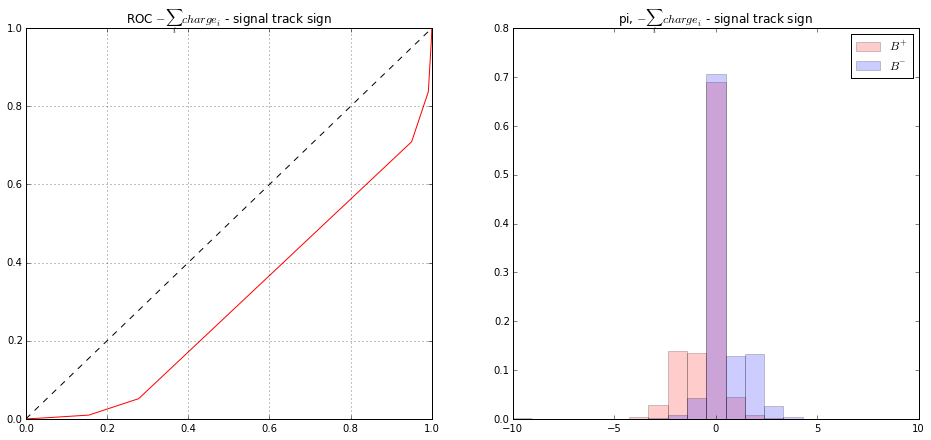

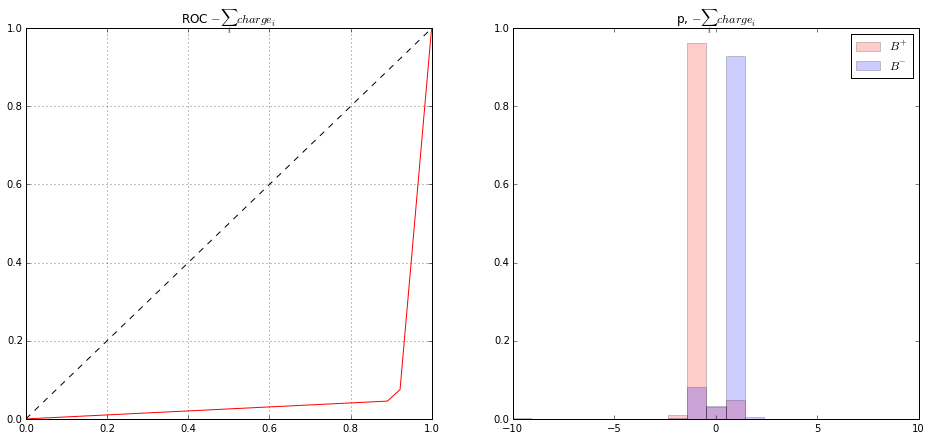

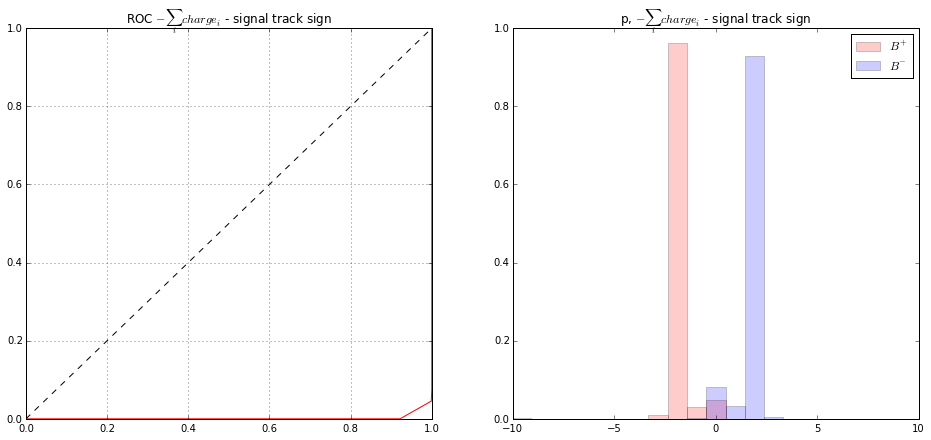

In [21]:
means_mcid_ss = [compute_sum_of_charges(data[mask], name, bins=bins,
                                event_id_column=event_id_column) for mask, name, bins in \
         zip([(numpy.abs(data.MCID) == 11) & (data.OS_SS >= 1), (numpy.abs(data.MCID) == 13) & (data.OS_SS >= 1), 
              (numpy.abs(data.MCID) == 321) & (data.OS_SS >= 1),
              (numpy.abs(data.MCID) == 211) & (data.OS_SS >= 1), (numpy.abs(data.MCID) == 2212) & (data.OS_SS >= 1)], 
             ['e', 'mu', 'K', 'pi', 'p'], [21, 21, 21, 21, 21])]

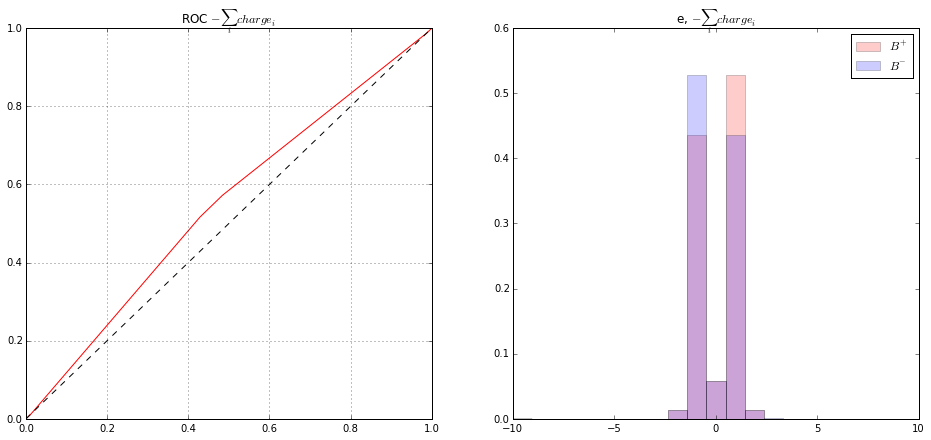

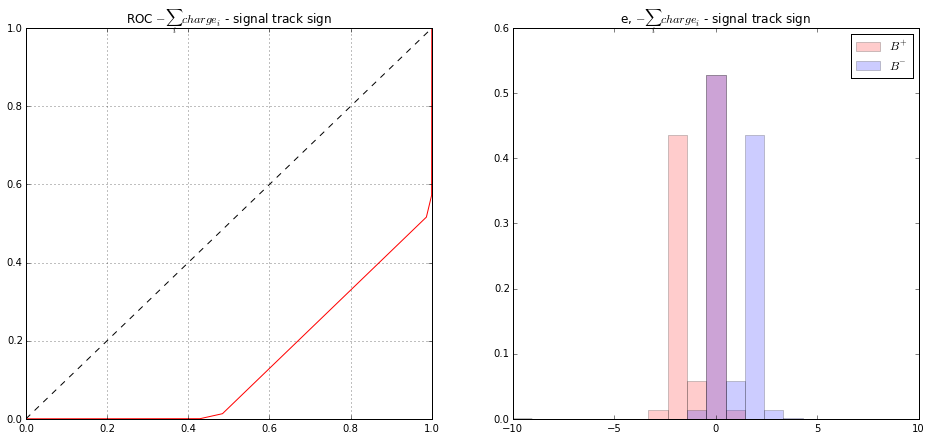

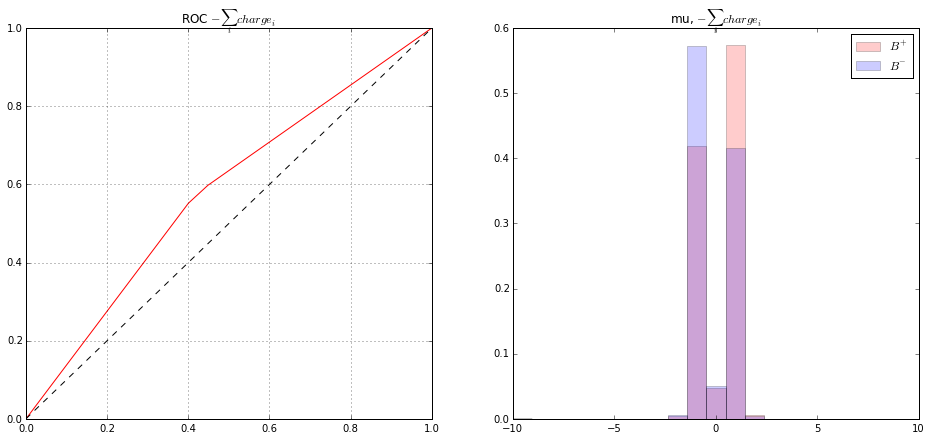

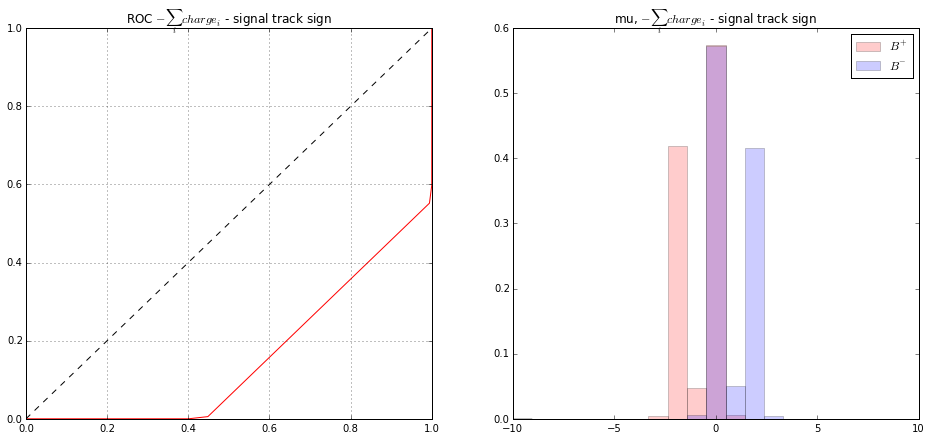

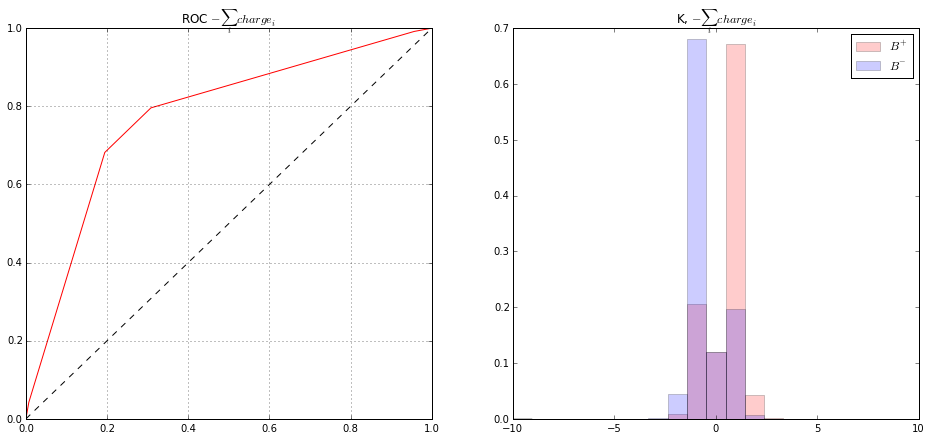

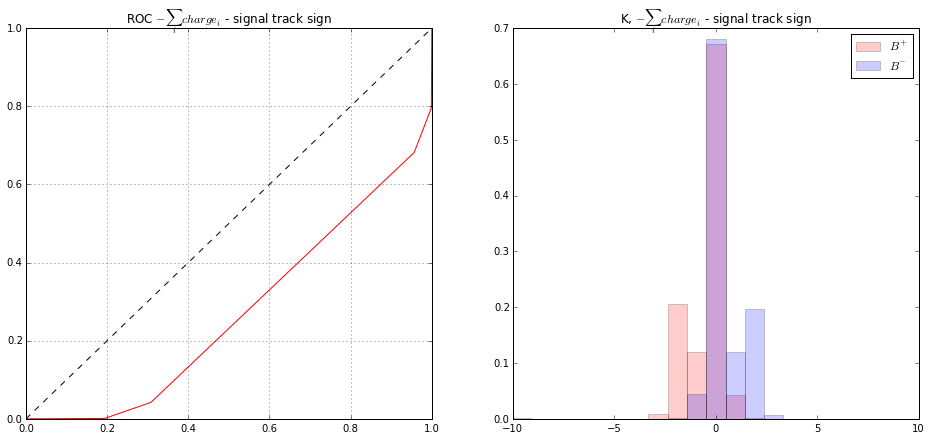

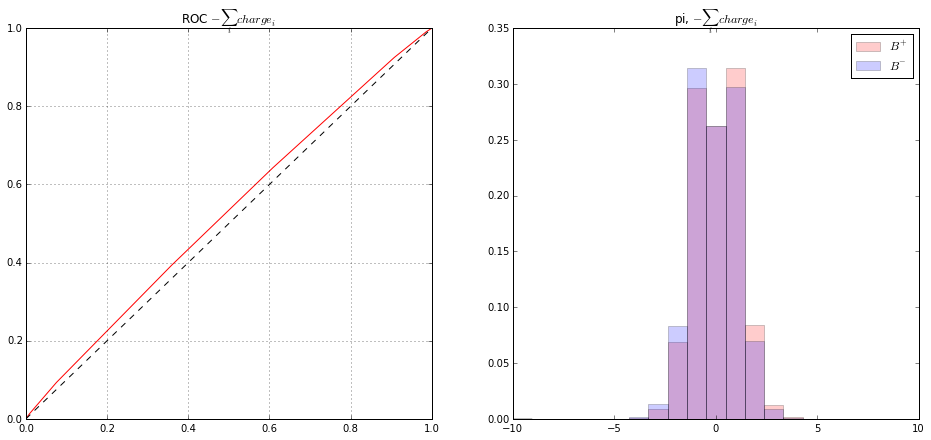

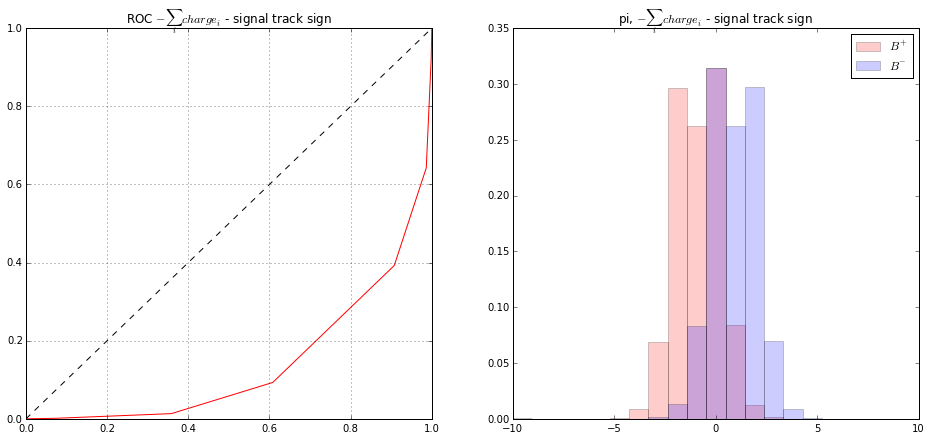

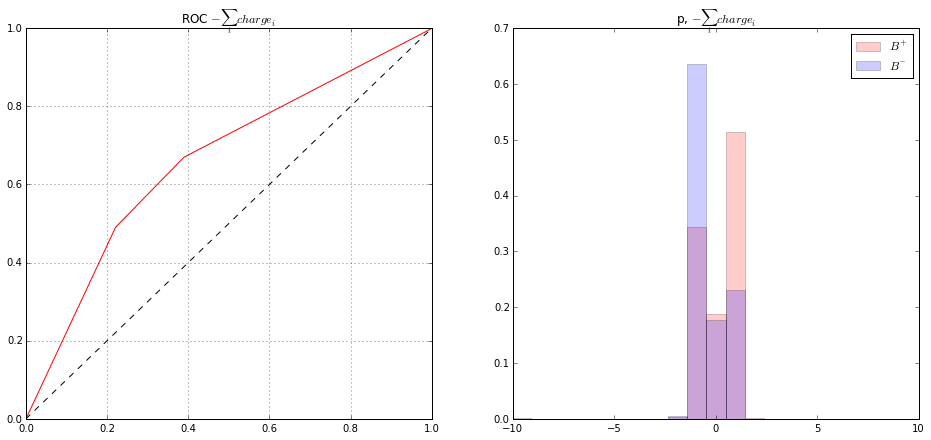

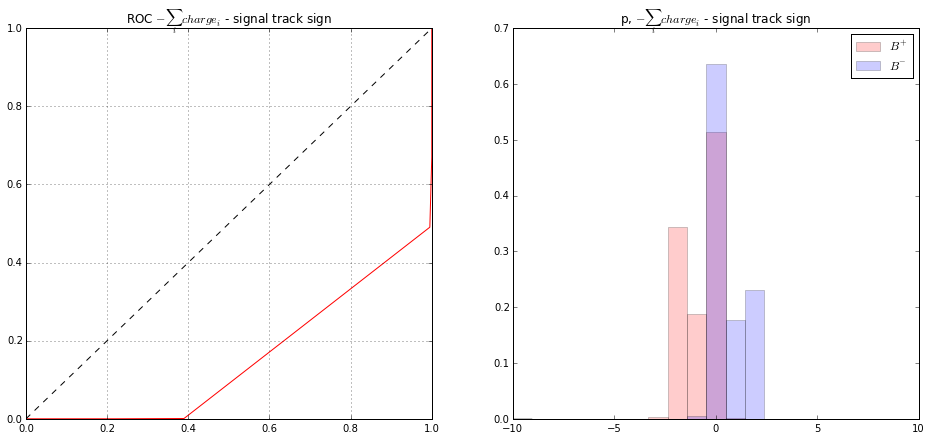

In [22]:
means_mcid_os = [compute_sum_of_charges(data[mask], name, bins=bins,
                                event_id_column=event_id_column) for mask, name, bins in \
         zip([(numpy.abs(data.MCID) == 11) & (data.OS_SS == -1), (numpy.abs(data.MCID) == 13) & (data.OS_SS == -1), 
              (numpy.abs(data.MCID) == 321) & (data.OS_SS == -1),
              (numpy.abs(data.MCID) == 211) & (data.OS_SS == -1), (numpy.abs(data.MCID) == 2212) & (data.OS_SS == -1)], 
             ['e', 'mu', 'K', 'pi', 'p'], [21, 21, 21, 21, 21])]

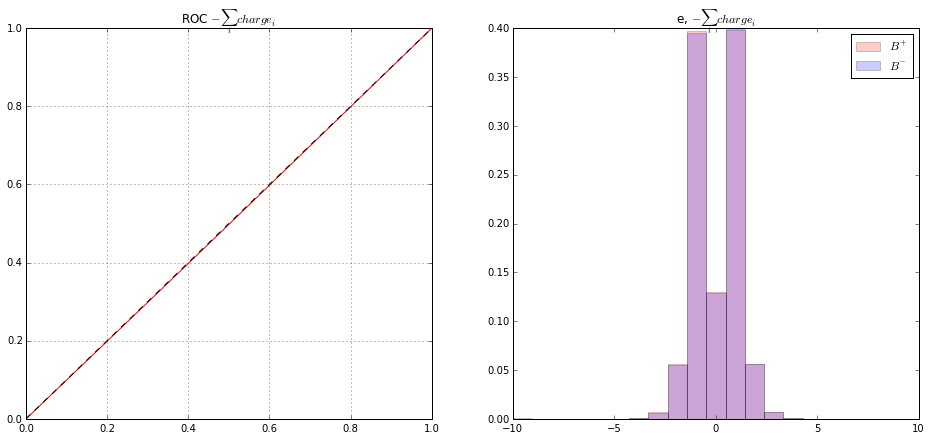

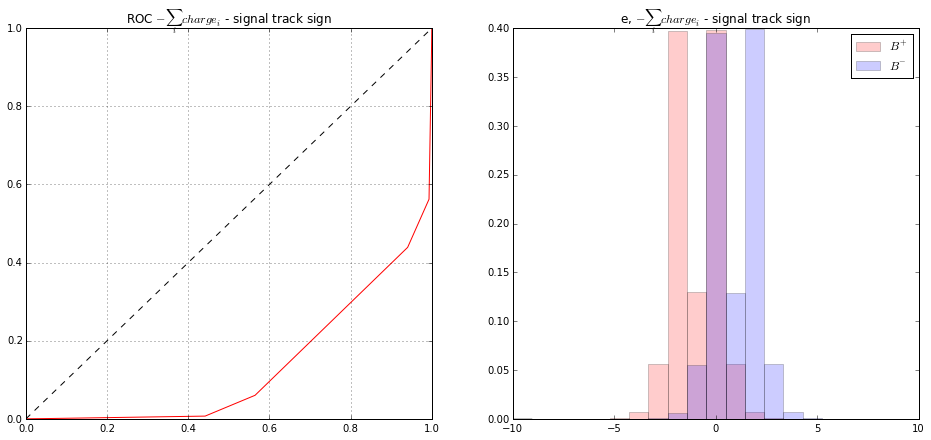

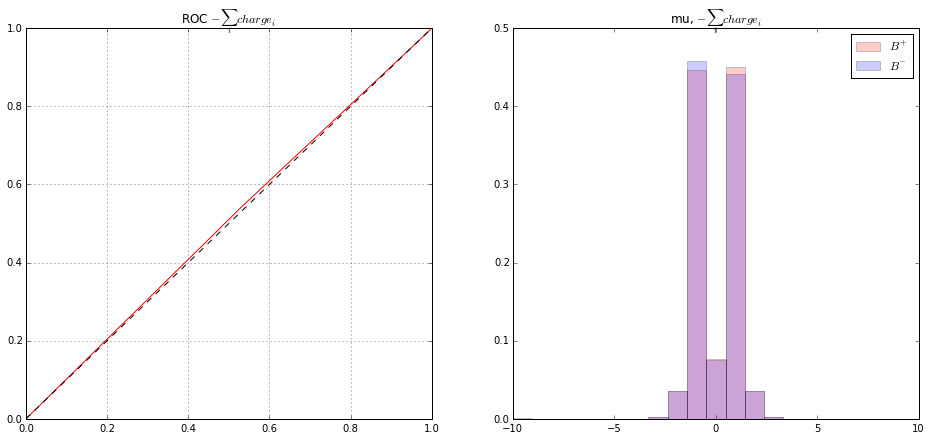

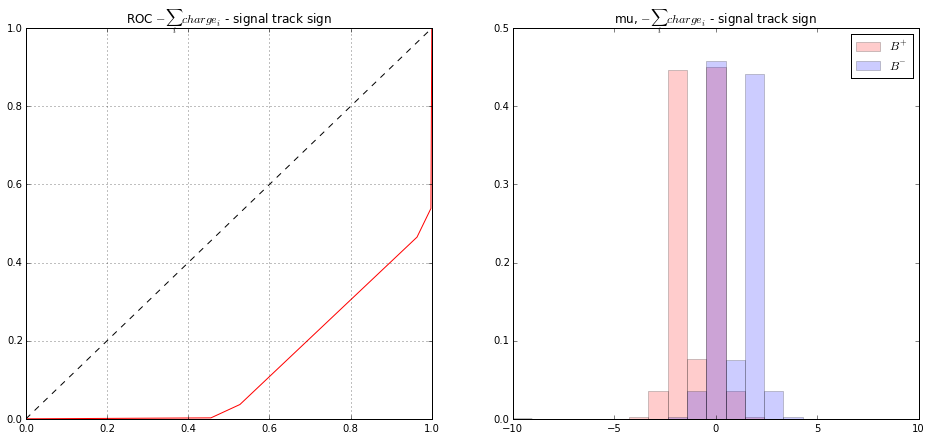

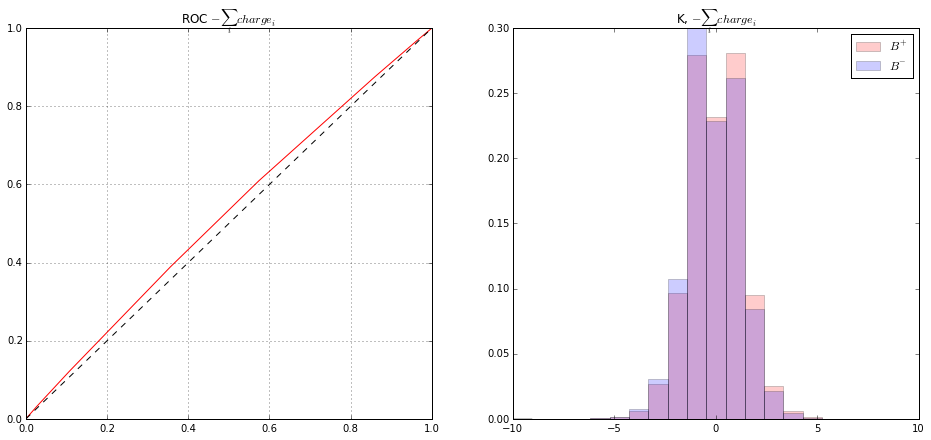

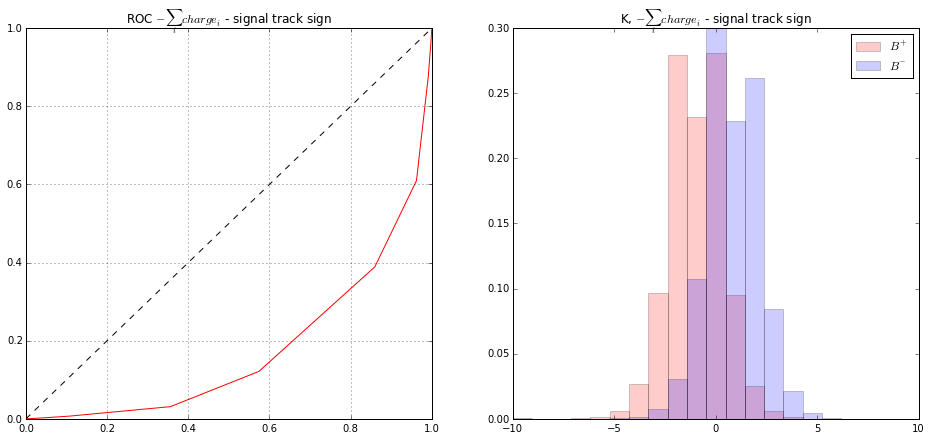

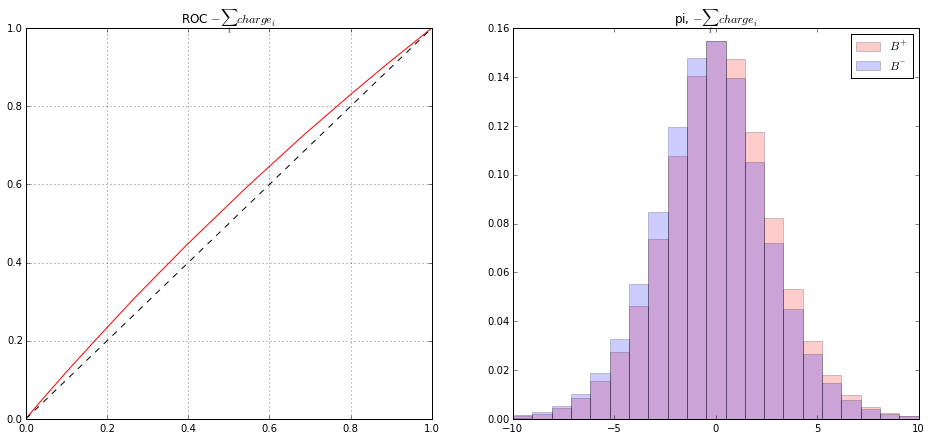

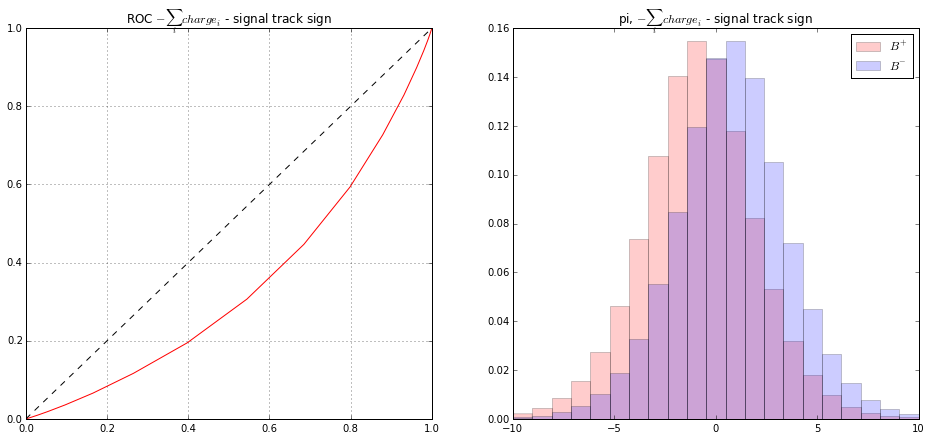

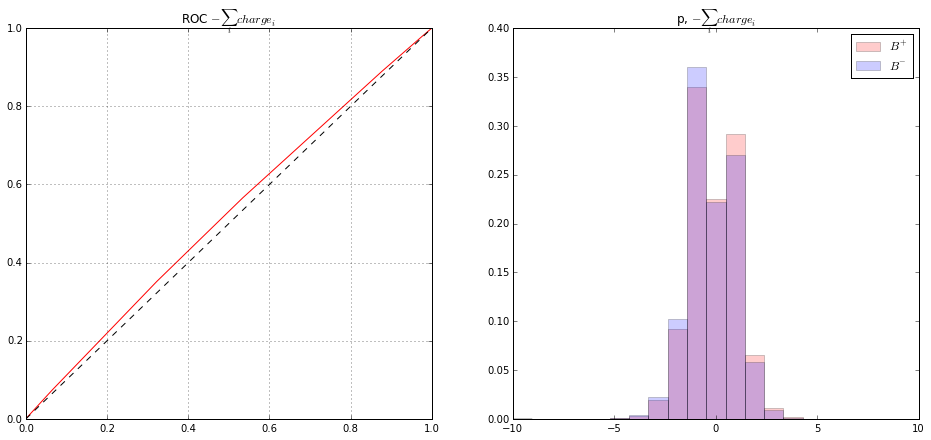

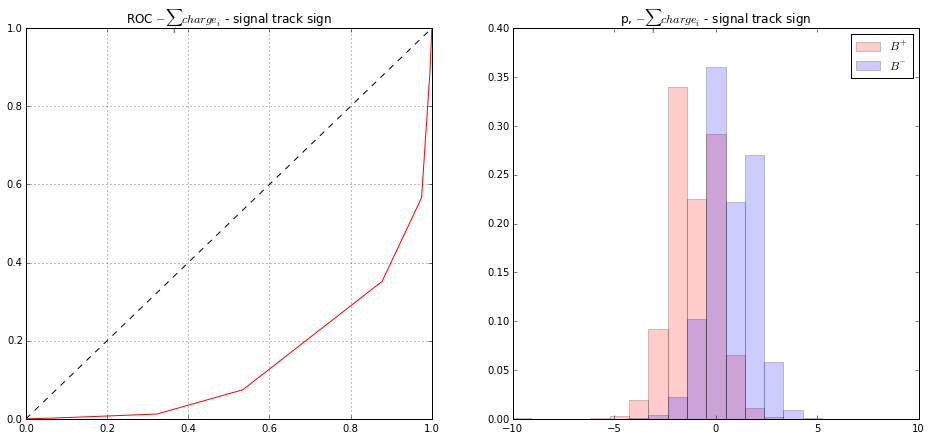

In [23]:
means_mcid_nan = [compute_sum_of_charges(data[mask], name, bins=bins,
                                event_id_column=event_id_column) for mask, name, bins in \
         zip([(numpy.abs(data.MCID) == 11) & (data.OS_SS == 0), (numpy.abs(data.MCID) == 13) & (data.OS_SS == 0), 
              (numpy.abs(data.MCID) == 321) & (data.OS_SS == 0),
              (numpy.abs(data.MCID) == 211) & (data.OS_SS == 0), (numpy.abs(data.MCID) == 2212) & (data.OS_SS == 0)], 
             ['e', 'mu', 'K', 'pi', 'p'], [21, 21, 21, 21, 21])]

In [24]:
pandas.concat(means)

,$B^+$,"$B^+$, with signal part",$B^-$,"$B^-$, with signal part",ROC AUC,"ROC AUC, with signal part",name
0,0.301028,-0.698972,-0.766497,0.233503,0.585087,0.574687,full
0,0.040453,-0.959547,-0.290346,0.709654,0.541318,0.699719,OS
0,0.149837,-0.850163,-0.181529,0.818471,0.566993,0.790395,SS


In [25]:
pandas.concat(means_mcid)

,$B^+$,"$B^+$, with signal part",$B^-$,"$B^-$, with signal part",ROC AUC,"ROC AUC, with signal part",name
0,0.029217,-0.970783,-0.020681,0.979319,0.511974,0.859131,e
0,0.069144,-0.930856,-0.077903,0.922097,0.536140,0.853671,mu
0,0.172858,-0.827142,-0.299909,0.700091,0.591501,0.766837,K
0,0.226336,-0.773664,-0.295750,0.704250,0.549268,0.636846,pi
0,-0.140544,-1.140544,-0.216291,0.783709,0.516964,0.852458,p


In [26]:
pandas.concat(means_mcid_os)

,$B^+$,"$B^+$, with signal part",$B^-$,"$B^-$, with signal part",ROC AUC,"ROC AUC, with signal part",name
0,0.088479,-0.911521,-0.087012,0.912988,0.545231,0.859251,e
0,0.151543,-0.848457,-0.152729,0.847271,0.578819,0.844342,mu
0,0.512594,-0.487406,-0.534809,0.465191,0.774959,0.730498,K
0,0.057672,-0.942328,-0.055855,0.944145,0.525310,0.860273,pi
0,0.157646,-0.842354,-0.393957,0.606043,0.661428,0.848368,p


In [27]:
pandas.concat(means_mcid_ss)

,$B^+$,"$B^+$, with signal part",$B^-$,"$B^-$, with signal part",ROC AUC,"ROC AUC, with signal part",name
0,0.195645,-0.804355,-0.185935,0.814065,0.597250,0.828033,e
0,0.426147,-0.573853,-0.422081,0.577919,0.716131,0.753349,mu
0,0.650909,-0.349091,-0.678630,0.321370,0.842083,0.666190,K
0,0.574459,-0.425541,-0.593488,0.406512,0.800424,0.700114,pi
0,-0.889316,-1.889316,0.816629,1.816629,0.064126,0.998184,p


In [28]:
pandas.concat(means_mcid_nan)

,$B^+$,"$B^+$, with signal part",$B^-$,"$B^-$, with signal part",ROC AUC,"ROC AUC, with signal part",name
0,0.001454,-0.998546,0.008042,1.008042,0.498468,0.868967,e
0,0.004419,-0.995581,-0.017349,0.982651,0.505388,0.869823,mu
0,-0.007226,-1.007226,-0.119068,0.880932,0.522737,0.824524,K
0,0.132178,-0.867822,-0.202235,0.797765,0.533312,0.660154,pi
0,-0.130252,-1.130252,-0.218605,0.781395,0.519977,0.852000,p


#### Calculating tagging efficiency ($\epsilon_{tag}$)

$$\epsilon_{tag} = \frac{N (\text{passed selection})} {N (\text{all events})}$$

$$\Delta\epsilon_{tag} = \frac{\sqrt{N (\text{passed selection})}} {N (\text{all events})}$$

In [29]:
N_B_passed = float(get_events_number(data))
tagging_efficiency = N_B_passed / N_B_events
tagging_efficiency_delta = sqrt(N_B_passed) / N_B_events
tagging_efficiency, tagging_efficiency_delta

(0.99999597015496766, 0.00081953531474227297)

# Main idea: 
## find tracks, which can help reconstruct the sign of B if you know track sign.

`label` = `signB` * `signTrack`
* the highest output means that this is same sign B as track
* the lowest output means that this is opposite sign B than track

## Define features

In [30]:
features = ['cos_diff_phi', 'diff_pt', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 
            'ptB', 'sum_PID_mu_k', 'proj', 'PIDNNe', 'sum_PID_k_e', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm',
            'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 
            'IPPU', 'eta', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs']

## PID pairs scatters

/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


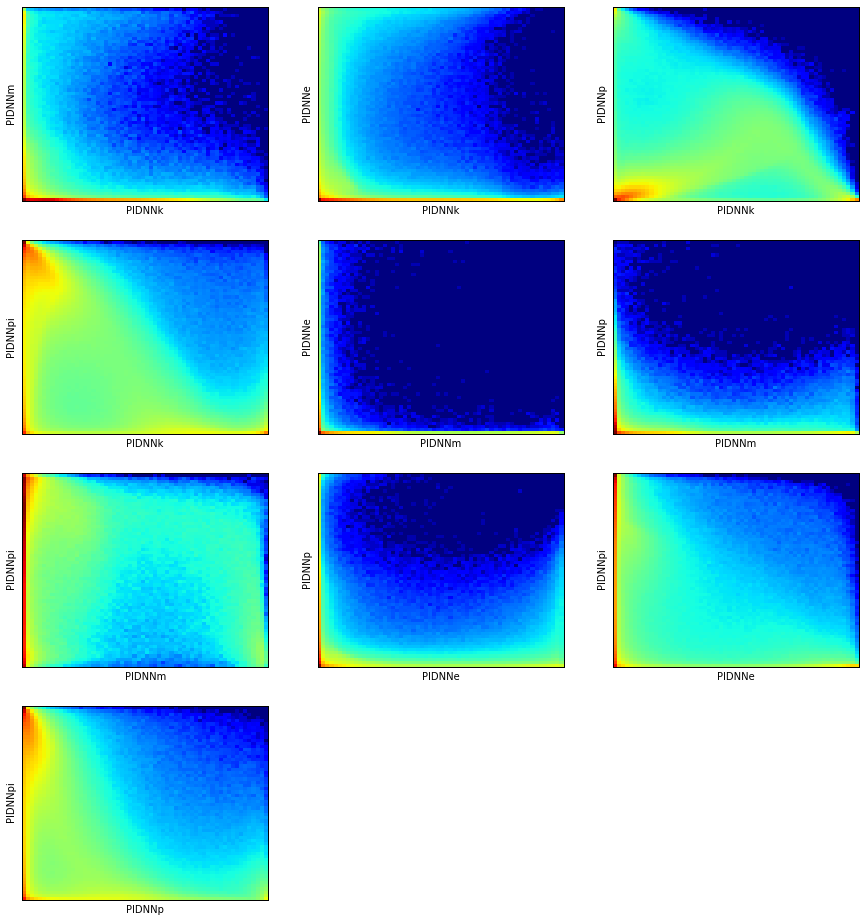

In [31]:
figure(figsize=[15, 16])
bins = 60
step = 3
for i, (feature1, feature2) in enumerate(combinations(['PIDNNk', 'PIDNNm', 'PIDNNe', 'PIDNNp', 'PIDNNpi'], 2)):
    subplot(4, 3, i + 1)
    Z, (x, y) = numpy.histogramdd(data[[feature1, feature2]].values, bins=bins, range=([0, 1], [0, 1]))
    pcolor(numpy.log(Z).T, vmin=0)
    xlabel(feature1)
    ylabel(feature2)
    xticks(numpy.arange(bins, step), x[::step]), yticks(numpy.arange(bins, step), y[::step])

## count of tracks

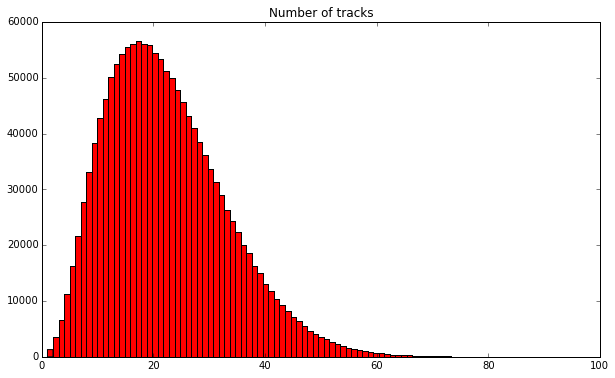

In [32]:
figure(figsize=(10, 6))

_, n_tracks_all = numpy.unique(data[event_id_column], return_counts=True)
hist(n_tracks_all, bins=100)    
title('Number of tracks')

----

## Train to distinguish same sign vs opposite sign

In [33]:
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier
from hep_ml.losses import LogLossFunction

In [34]:
data_sw_passed_lds = LabeledDataStorage(data, data.label)

### DT

In [35]:
tt_base = DecisionTrainClassifier(learning_rate=0.1, n_estimators=3000, depth=6,
                                  max_features=15, n_threads=12, loss=LogLossFunction(regularization=100))
tt_folding = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11, 
                                    train_features=features, group_feature='group_column')
%time tt_folding.fit_lds(data_sw_passed_lds)
pass

CPU times: user 1h 46min 19s, sys: 40min 35s, total: 2h 26min 55s
Wall time: 57min 5s


In [36]:
import cPickle
with open('models/dt_MC.pkl', 'w') as f:
    cPickle.dump(tt_folding, f)

In [35]:
import cPickle
with open('models/dt_MC.pkl', 'r') as f:
    tt_folding = cPickle.load(f)

In [36]:
comparison_report = tt_folding.test_on_lds(data_sw_passed_lds)

KFold prediction using folds column


In [37]:
comparison_report.compute_metric(RocAuc())

OrderedDict([('clf', 0.51695060937469905)])

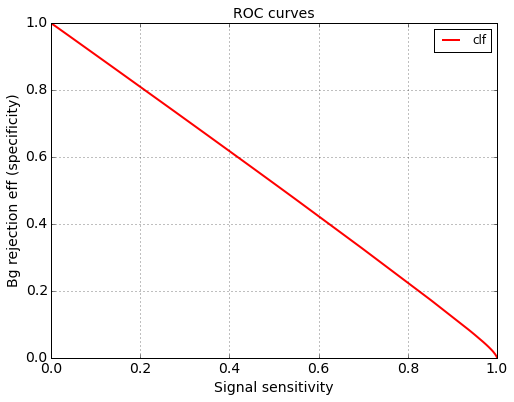

In [38]:
comparison_report.roc()

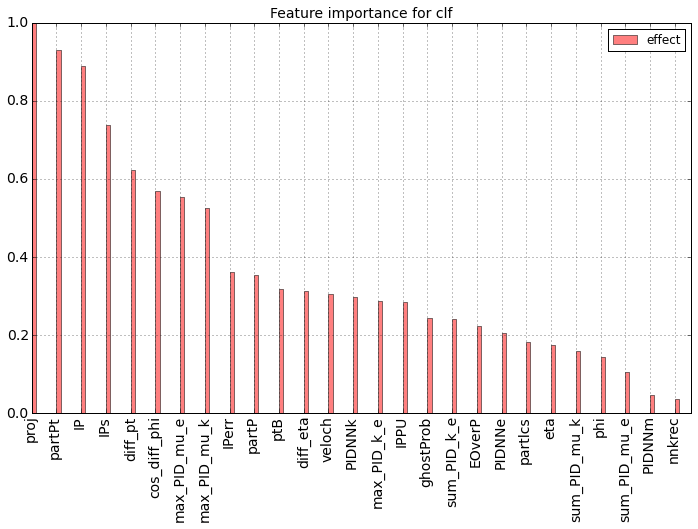

In [39]:
comparison_report.feature_importance()

---------

# Calibration

In [40]:
from utils import get_result_with_bootstrap_for_given_part

KFold prediction using folds column


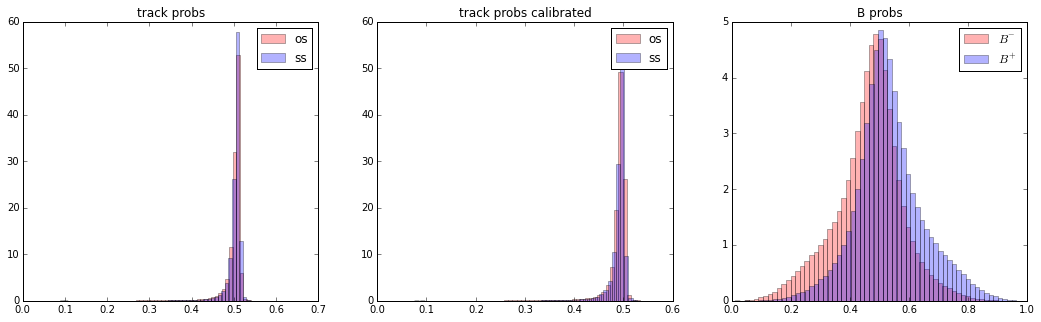

AUC for tagged: 0.660862887523 AUC with untag: 0.660862501017


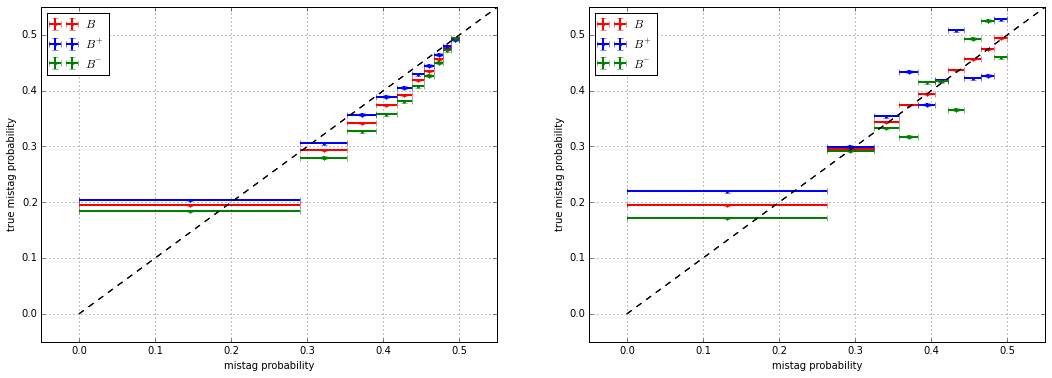

mean AUC after calibration: 0.660821195051 1.14190076682e-07


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,tt-log,99.999597,0.081954,0.08195,0.000387,8.194972,0.03928,66.08625,0


In [ ]:
result = get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                  [data], 'tt-log', logistic=True, N_B_events=N_B_events, 
                                                  n_calibrations=30)
result

In [57]:
result.to_csv('img/tracks_MC.csv', index=False, header=True)

-------------------------------

In [58]:
from utils import calibrate_probs, get_B_data_for_given_part
from utils import plot_calibration

### track calibration

In [60]:
p_track_calibrated, calibrator_tracks = calibrate_probs(data.label.values, data.N_sig_sw.values, 
                                                        tt_folding.predict_proba(data)[:, 1],
                                                        logistic=True, return_calibrator=True, with_prediction=True)

KFold prediction using folds column


In [61]:
roc_auc_score(data.label, p_track_calibrated)

0.51692406986089656

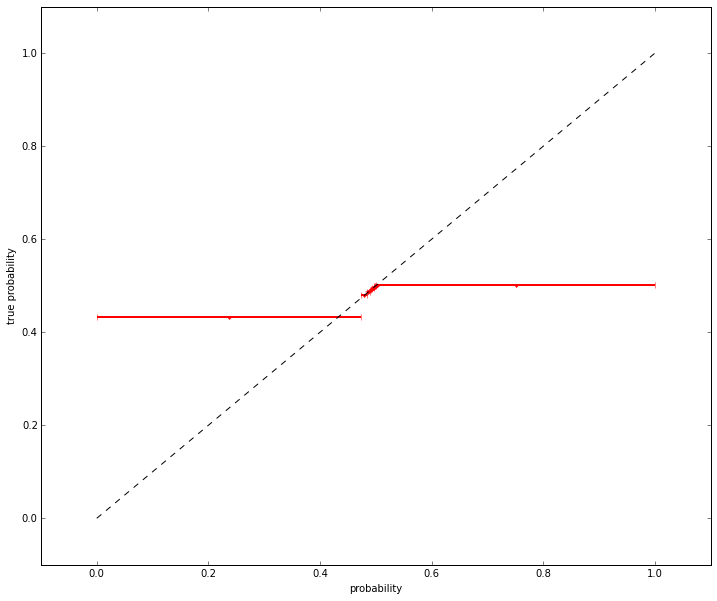

In [62]:
plot_calibration(p_track_calibrated, data.label.values)

### p(B) calibration

KFold prediction using folds column


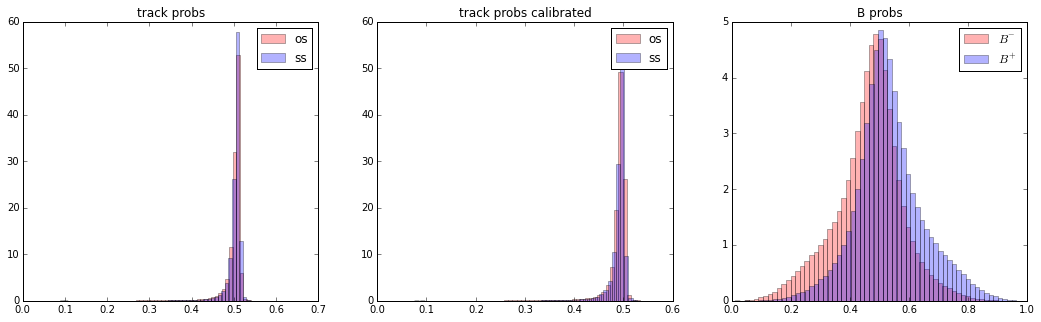

AUC for tagged: 0.660862887523 AUC with untag: 0.660862501017


In [63]:
Bsign, Bweight, Bprob, Bevent, auc_full = get_B_data_for_given_part(tt_folding, [data], logistic=True, 
                                                                    N_B_events=N_B_events) 

In [64]:
Bprob_calibrated, calibrator_B = calibrate_probs(Bsign, Bweight, Bprob, symmetrize=True,
                                                 return_calibrator=True, with_prediction=True)

In [65]:
Bprob_calibrated_noise = Bprob_calibrated + numpy.random.normal(size=len(Bprob_calibrated)) * 0.001

In [66]:
from utils import compute_mistag

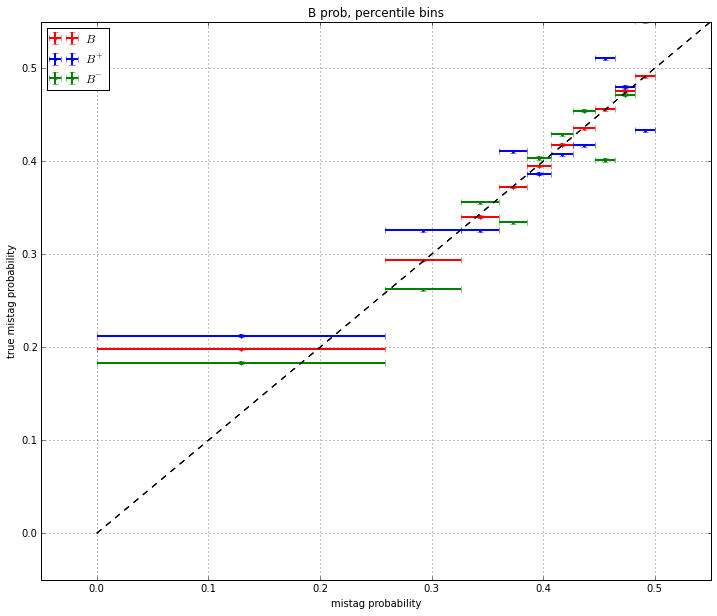

In [67]:
bins = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
percentile_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]

figsize(12, 10)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob, percentile bins')

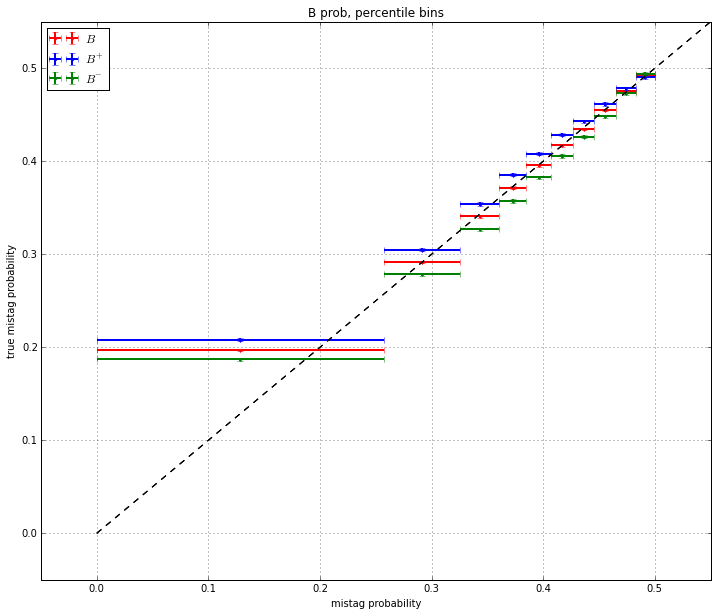

In [68]:
figsize(12, 10)
compute_mistag(Bprob_calibrated_noise, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob_calibrated_noise, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob_calibrated_noise, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob, percentile bins')

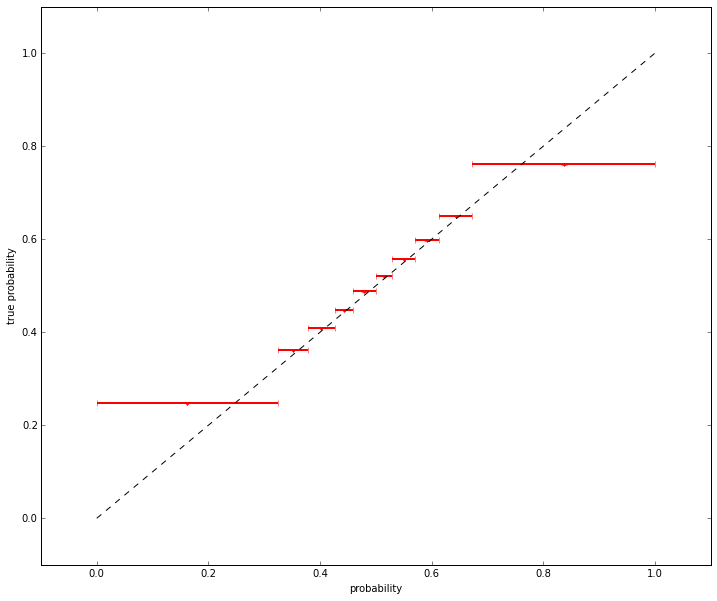

In [69]:
plot_calibration(Bprob_calibrated, Bsign > 0)

In [70]:
with open('models/calibrator_tracks_MC.pkl', 'w') as f:
    cPickle.dump(calibrator_tracks, f)
with open('models/calibrator_B_MC.pkl', 'w') as f:
    cPickle.dump(calibrator_B, f)

--------------------------

# Normed signs

KFold prediction using folds column


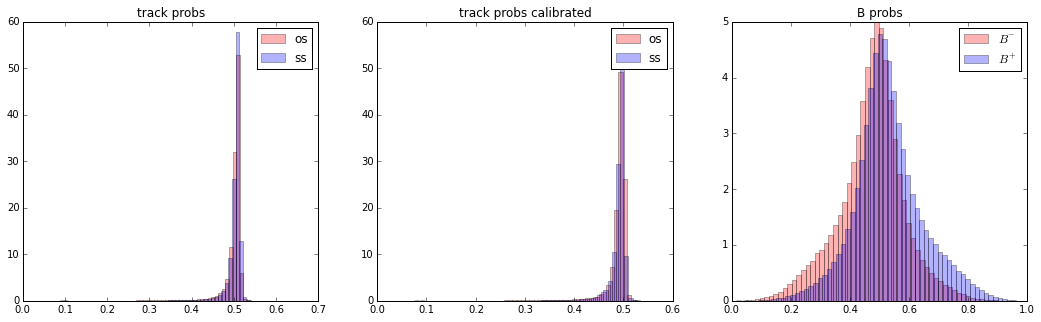

AUC for tagged: 0.632458850195 AUC with untag: 0.63245852048
mean AUC after calibration: 0.632095653782 0.0


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,tt-log,99.999597,0.081954,0.057567,0,5.756726,0.004718,63.245852,0


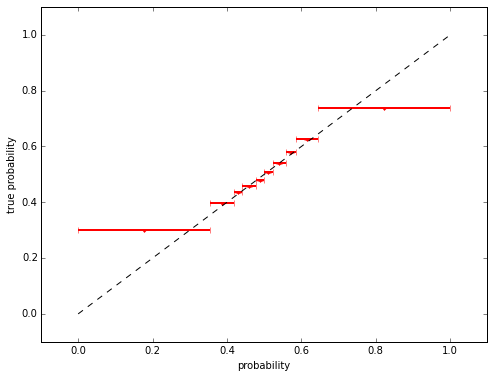

In [53]:
result_normed = get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                         [data], 'tt-log', logistic=True, normed_signs=True,
                                                         N_B_events=N_B_events, n_calibrations=1)
result_normed

## Save model for combination with vertex 

In [71]:
from utils import prepare_B_data_for_given_part

KFold prediction using folds column


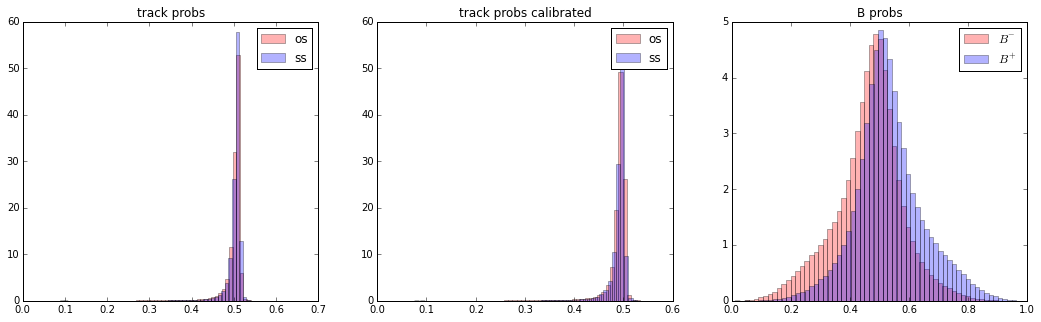

AUC for tagged: 0.660862887523 AUC with untag: 0.660862501017


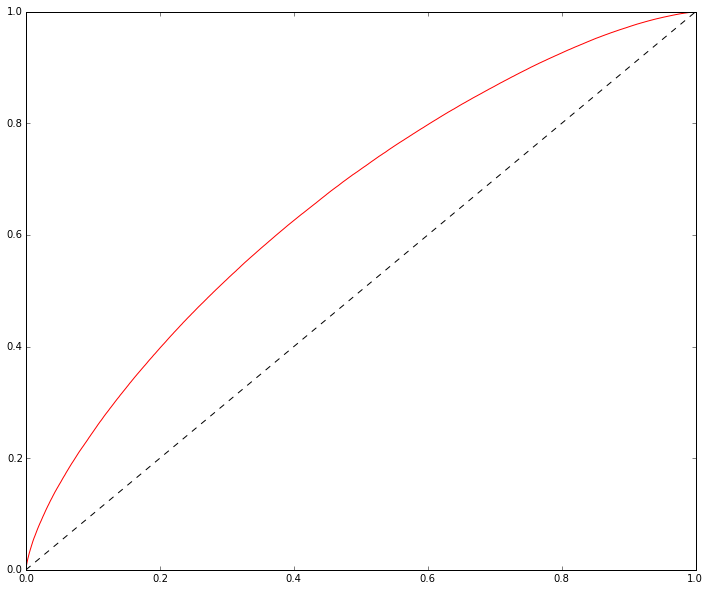

In [72]:
Bdata_prepared = prepare_B_data_for_given_part(tt_folding, [data], logistic=True, N_B_events=N_B_events)

In [73]:
Bdata_prepared.to_csv('models/Bdata_tracks_MC.csv', header=True, index=False)

In [75]:
from utils import predict_by_estimator
part_data, part_prob = predict_by_estimator(tt_folding, [data])
pandas.DataFrame({'label': part_data.label.values,
                  'weight': part_data.N_sig_sw, 
                  'part_prob': part_prob,
                  'OS_SS': part_data.OS_SS,
                  'xFlag': part_data.xFlag}).to_csv('models/part_tracks_MC.csv', header=True, index=False)

KFold prediction using folds column
